# 傾き補正

スキャン時に少し傾けてスキャンしてしまった画像があるとする。

画像の分析の前処理として、画像の傾きを水平に直してから処理したい…という状況を想定する

## 表など、まっすぐな直線の要素がある場合

スキャンした画像が会計の資料などで表が中心の画像だと、表の直線を検知して傾きを計算するのがよさそう

手順：

1. 線の検出
    1. 例：Canny法でエッジを推定→ハフ変換で表の直線を推定
    2. 例：FastLineDetection
2. 直線の角度を計算
3. 補正すべき角度を計算
4. 回転して補正

### Canny法によるEdge Detection

[OpenCV: Canny Edge Detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)


### ハフ変換

- [OpenCV: Hough Line Transform](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)
- [ハフ変換 (Hough Transform) による直線・円の検出 | CVMLエキスパートガイド](https://cvml-expertguide.net/terms/cv/image-feature-detection/hough-transform/)
- [ハフ変換による直線検出 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

### 回転

[OpenCV: Affine Transformations](https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html)

### サンプル画像の生成


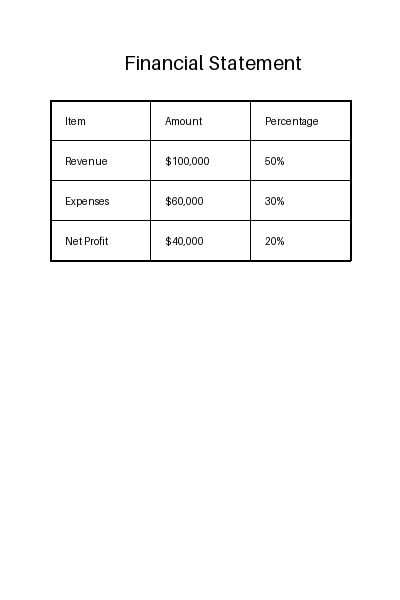

In [1]:
from PIL import Image, ImageDraw, ImageFont

def create_image():
    # 画像サイズを指定
    img_width, img_height = 400, 600
    # 背景色の指定（白）
    background_color = (255, 255, 255)
    # 画像の作成
    image = Image.new('RGB', (img_width, img_height), background_color)
    draw = ImageDraw.Draw(image)
    
    font = ImageFont.load_default()
    
    # タイトルの描画
    title = "Financial Statement"
    title_position = (img_width // 2 - len(title) * 4, 50)
    draw.text(title_position, title, fill=(0, 0, 0), font=ImageFont.load_default(size=20))

    width = 100
    margin = 15

    # 表のヘッダー部分
    headers = ["Item", "Amount", "Percentage"]
    header_position = (50, 100)
    for i, header in enumerate(headers):
        draw.text((header_position[0] + i * width + margin, header_position[1] + margin), header, fill=(0, 0, 0), font=font)
    
    # 表データの例
    data = [
        ("Revenue", "$100,000", "50%"),
        ("Expenses", "$60,000", "30%"),
        ("Net Profit", "$40,000", "20%")
    ]
    
    # 表の内容を描画
    for row, (item, amount, percentage) in enumerate(data):
        cols = (item, amount, percentage)
        for j, value in enumerate(cols):
            draw.text((header_position[0] + j * width + margin, header_position[1] + (row + 1) * 40 + margin), value, fill=(0, 0, 0), font=font)
    
    # 表の線を描画
    line_start_x, line_end_x = 50, 350
    row_idx = list(range(len(data) + 2))
    for i in range(len(data) + 2):
        y = header_position[1] + i * 40
        line_width = 2 if i in (min(row_idx), max(row_idx)) else 1
        draw.line([(line_start_x, y), (line_end_x, y)], fill=(0, 0, 0), width=line_width)
    
    # 垂直線を描画
    ncols = len(cols)
    col_idx = list(range(ncols + 1))
    for j in range(ncols + 1):
        line_width = 2 if j in (min(col_idx), max(col_idx)) else 1
        draw.line([(line_start_x + j * width, header_position[1]),
                   (line_start_x + j * width, header_position[1] + (len(data) + 1) * 40)],
                  fill=(0, 0, 0), width=line_width)
    return image

image = create_image()
image

傾かせる

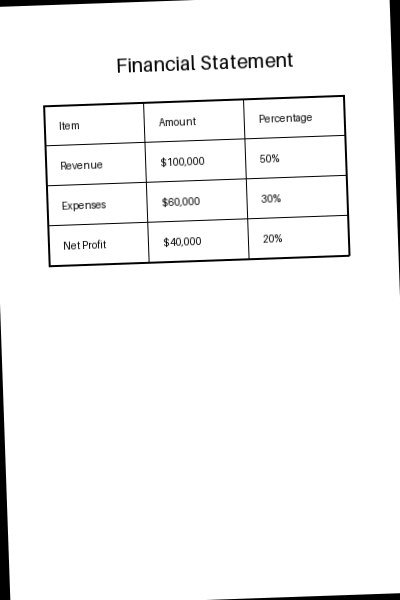

In [2]:
import cv2
import numpy as np

def rotate_image(image: Image) -> np.array:
    image = np.array(image)
    
    # 回転の中心を画像の中心に設定
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # 回転のための行列を生成。この例では画像を中心に90度回転
    angle = 2  # 回転角度
    scale = 1.0  # スケールは変更しない
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    
    # アフィン変換を適用して画像を回転
    image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return image

image = rotate_image(image)
Image.fromarray(image)

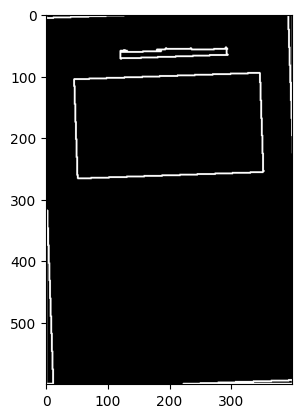

In [3]:
import matplotlib.pyplot as plt

def get_contour(image):
    # グレースケール画像の取得
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 二値化
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    
    # モルフォロジー変換：膨張と収縮を繰り返して線を抽出
    kernel_length = max(1, image.shape[1] // 80)  # カーネルのサイズを画像の幅に基づいて決定
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # 輪郭を取得
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(gray)
    # 輪郭を描画
    cv2.drawContours(contour_img, contours, -1, (255, 255, 255), 2)
    return contour_img


# 前処理：表の輪郭線を取り出す
image = get_contour(image)

plt.imshow(image, cmap="gray")
plt.show()

## 1. ハフ変換による線検出



#### Canny法によるエッジ検出

今回の表については不要かも…？

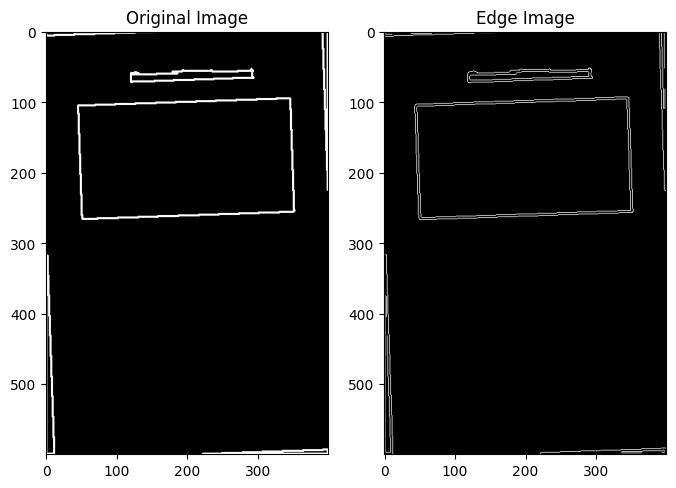

In [4]:
import cv2
import matplotlib.pyplot as plt

# グレースケールに変換
if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Cannyエッジ検出を適用
edges = cv2.Canny(image, threshold1=100, threshold2=200)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 結果を表示
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Image')
plt.show()

#### ハフ変換

HoughLinesとHoughLinesPの違い：

- HoughLinesはすべての点の線を取る
- HoughLinesPは確率的で、ランダムサンプリングした点だけ計算するので効率がいい

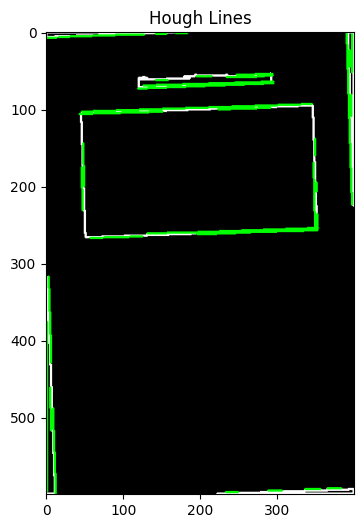

In [5]:
# ハフ変換で直線を検出
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/360, threshold=80, minLineLength=10, maxLineGap=5)

# 検出した直線を元の画像に描画
image_for_plot = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_for_plot, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 結果を表示
plt.figure(figsize=(8, 6))
plt.imshow(image_for_plot)
plt.title('Hough Lines')
plt.show()

#### 角度の算出

In [6]:
def calc_angle(x1, y1, x2, y2):
    """線の傾きの角度を計算する"""
    # 三角形の横xと縦yを取得
    point1 = np.array([x1, y1])
    point2 = np.array([x2, y2])
    x = point2 - point1
    y = np.array([1, 0])
    # cos θ
    cos_theta = x @ y / np.linalg.norm(x) * np.linalg.norm(y)
    # cos^{-1}でθ（ラジアン）を取得
    radian = np.arccos(cos_theta)
    # radian to degree
    degree = radian * (180 / np.pi)
    return degree


In [7]:
# 複数の線の角度を集計
angles = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    angle = calc_angle(x1, y1, x2, y2)
    angles.append(angle)
angles = np.array(angles)

# 縦線は文字の角度を拾っている物が多いので水平に近い線だけをとる
angles = angles[angles < 45]
# 平均をとる
angle = np.mean(angles)
angle

0.9514779758679796

#### 回転

**`getRotationMatrix2D`**

[OpenCV: Geometric Image Transformations](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326)

affine matrix 

$$
\begin{bmatrix}
\alpha & \beta & (1- \alpha ) \cdot \texttt{center.x} - \beta \cdot \texttt{center.y} \\
- \beta & \alpha & \beta \cdot \texttt{center.x} + (1- \alpha ) \cdot \texttt{center.y}
\end{bmatrix}
$$

$$
\begin{array}{l}
\alpha = \texttt{scale} \cdot \cos \texttt{angle},\\
\beta = \texttt{scale} \cdot \sin \texttt{angle}
\end{array}
$$

を取得する

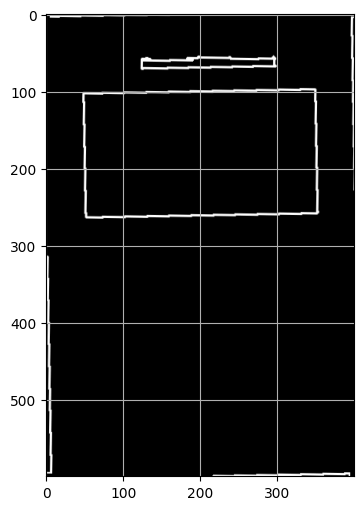

In [8]:
# 回転の中心を画像の中心に設定
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

scale = 1.0  # スケールは変更しない
rotation_matrix = cv2.getRotationMatrix2D(center, -angle, scale)

# アフィン変換を適用して画像を回転
image = cv2.warpAffine(image, rotation_matrix, (w, h))

# 結果を表示
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.grid(True)
plt.show()

## 2. FastLineDetectorによる線検出

pylsdパッケージのLSDを使ったほうがもっといいかも？

In [50]:
# サンプルデータの生成
image = create_image()
image = rotate_image(image)
image = get_contour(image)

32 lines are detected


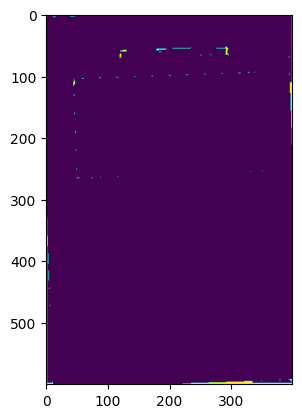

In [51]:
length_threshold = 10
distance_threshold = 1.41421356
canny_th1 = 50
canny_th2 = 50
canny_aperture_size = 3
do_merge = False

fld = cv2.ximgproc.createFastLineDetector(
    length_threshold,
    distance_threshold,
    canny_th1,
    canny_th2,
    canny_aperture_size,
    do_merge
)

lines_raw = fld.detect(image)
# 形状を整える
lines = [line[0] for line in lines_raw]

# # drawSegmentsで描く場合
# img_lines = fld.drawSegments(image, lines)
# plt.imshow(img_lines)

# cv2.lineで描く場合
print(f"{len(lines)} lines are detected")
out = image.copy()
for line in lines:
    x1, y1, x2, y2 = map(int, line)
    cv2.line(out, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(out)

#### 角度の算出

In [52]:
# 複数の線の角度を集計
angles = []
for line in lines:
    x1, y1, x2, y2 = map(int, line)
    angle = calc_angle(x1, y1, x2, y2)
    angles.append(angle)
angles = np.array(angles)

# 縦線は文字の角度を拾っている物が多いので水平に近い線だけをとる
angles = angles[angles < 45]
# 平均をとる
angle = np.mean(angles)
angle

1.6194360861896437

#### 回転

**`getRotationMatrix2D`**

[OpenCV: Geometric Image Transformations](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326)

affine matrix 

$$
\begin{bmatrix}
\alpha & \beta & (1- \alpha ) \cdot \texttt{center.x} - \beta \cdot \texttt{center.y} \\
- \beta & \alpha & \beta \cdot \texttt{center.x} + (1- \alpha ) \cdot \texttt{center.y}
\end{bmatrix}
$$

$$
\begin{array}{l}
\alpha = \texttt{scale} \cdot \cos \texttt{angle},\\
\beta = \texttt{scale} \cdot \sin \texttt{angle}
\end{array}
$$

を取得する

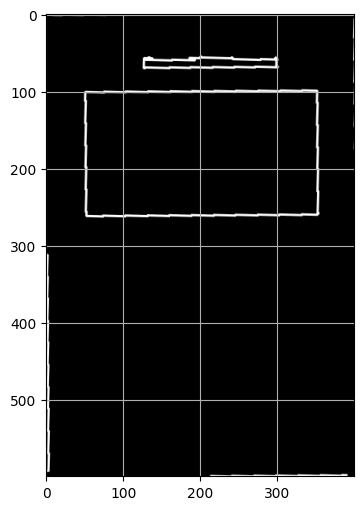

In [53]:
# 回転の中心を画像の中心に設定
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

scale = 1.0  # スケールは変更しない
rotation_matrix = cv2.getRotationMatrix2D(center, -angle, scale)

# アフィン変換を適用して画像を回転
image = cv2.warpAffine(image, rotation_matrix, (w, h))

# 結果を表示
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.grid(True)
plt.show()